Running specialized water environment detection...


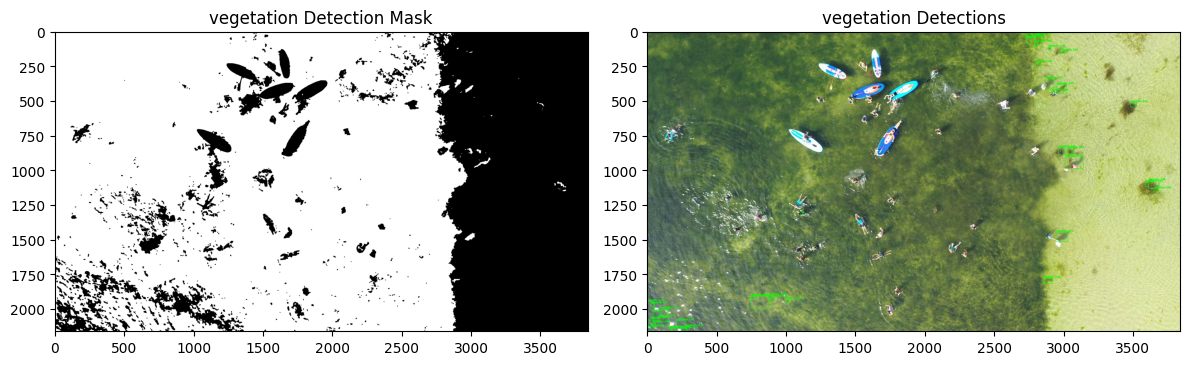

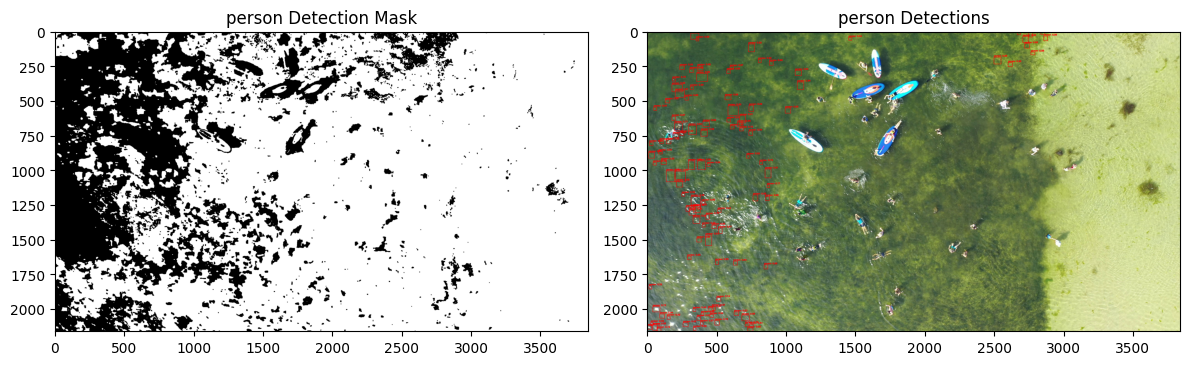

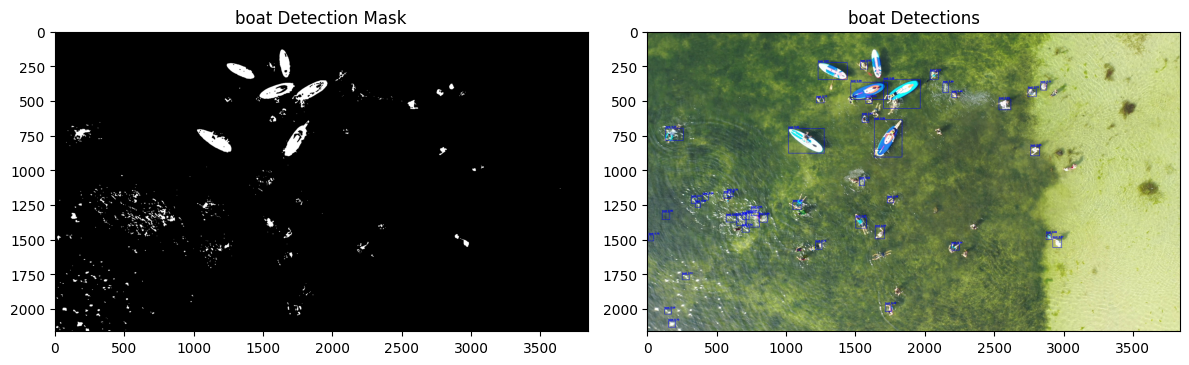

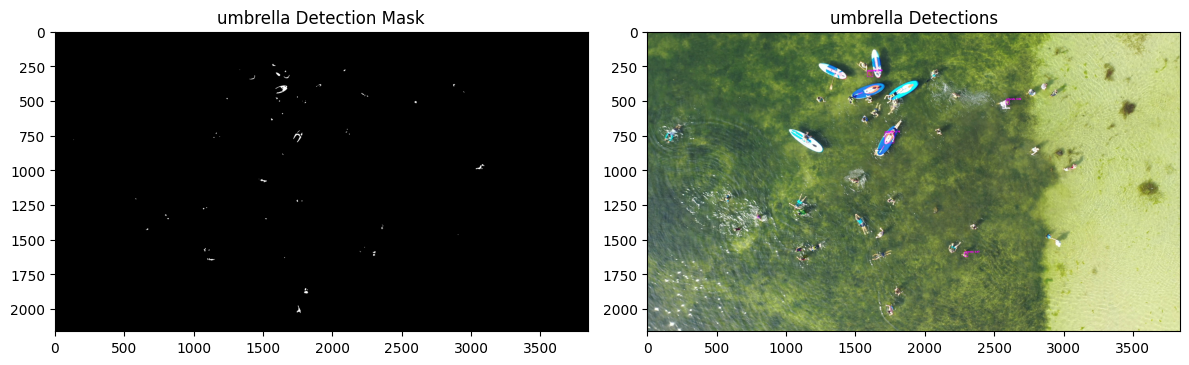

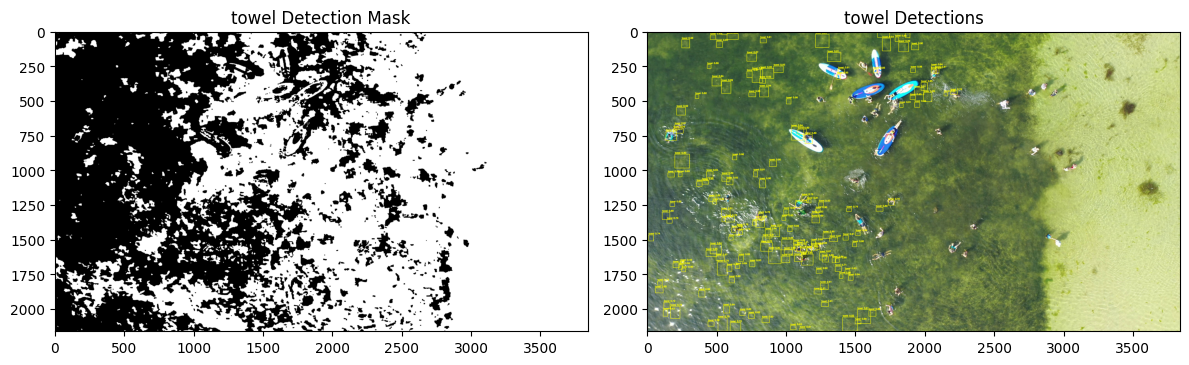

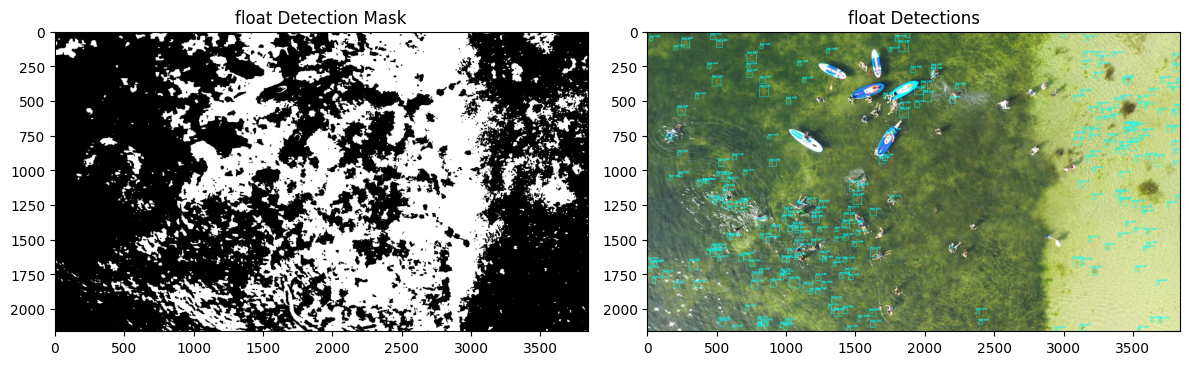

Results saved to water_environment_detections.jpg
Detected 557 meaningful objects:
  vegetation: 41 objects
    - vegetation 1: confidence 0.96, position: (2889, 115), size: 23x21
    - vegetation 2: confidence 0.96, position: (2790, 80), size: 25x30
    - vegetation 3: confidence 0.96, position: (2951, 385), size: 68x65
    - vegetation 4: confidence 0.95, position: (3651, 1136), size: 36x23
    - vegetation 5: confidence 0.95, position: (2980, 143), size: 34x20
    - vegetation 6: confidence 0.94, position: (2795, 27), size: 50x71
    - vegetation 7: confidence 0.94, position: (2773, 6), size: 27x23
    - vegetation 8: confidence 0.93, position: (2727, 13), size: 50x36
    - vegetation 9: confidence 0.93, position: (3591, 1090), size: 22x29
    - vegetation 10: confidence 0.92, position: (2946, 1448), size: 87x66
    - vegetation 11: confidence 0.92, position: (3026, 846), size: 49x39
    - vegetation 12: confidence 0.91, position: (2708, 0), size: 57x29
    - vegetation 13: confiden

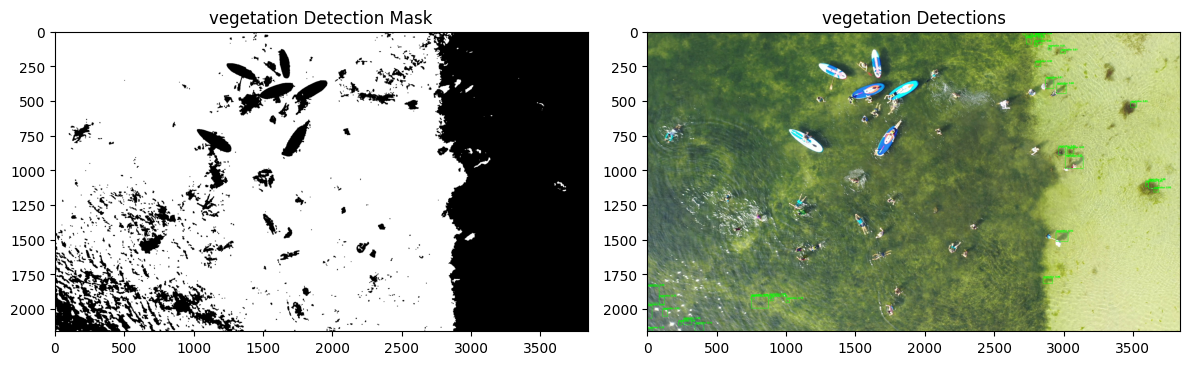

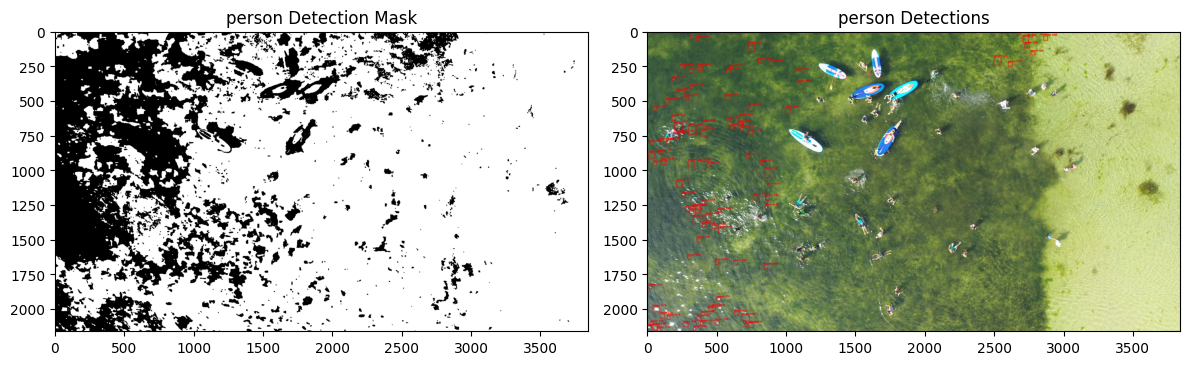

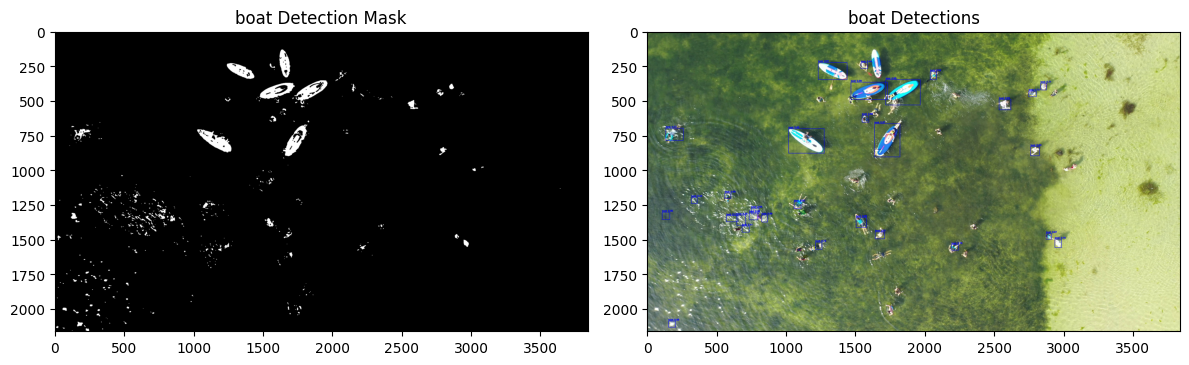

Results saved to specific_class_detections.jpg
Detected 164 meaningful objects:
  vegetation: 35 objects
    - vegetation 1: confidence 0.96, position: (2790, 80), size: 25x30
    - vegetation 2: confidence 0.96, position: (2951, 385), size: 68x65
    - vegetation 3: confidence 0.95, position: (3651, 1136), size: 36x23
    - vegetation 4: confidence 0.94, position: (2795, 27), size: 50x71
    - vegetation 5: confidence 0.93, position: (2727, 13), size: 50x36
    - vegetation 6: confidence 0.92, position: (2946, 1448), size: 87x66
    - vegetation 7: confidence 0.92, position: (3026, 846), size: 49x39
    - vegetation 8: confidence 0.91, position: (2708, 0), size: 57x29
    - vegetation 9: confidence 0.91, position: (2871, 343), size: 60x70
    - vegetation 10: confidence 0.90, position: (2733, 46), size: 35x47
    - vegetation 11: confidence 0.90, position: (2795, 226), size: 42x31
    - vegetation 12: confidence 0.89, position: (2819, 0), size: 44x49
    - vegetation 13: confidence 0.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from scipy import ndimage
from sklearn.cluster import DBSCAN, KMeans
from scipy.spatial import distance
import os
from collections import defaultdict

class MeaningfulObjectDetector:
    """
    General-purpose detector for meaningful objects in aerial water imagery.
    Capable of identifying multiple object classes based on appearance characteristics.
    """
    
    def __init__(self, config=None):
        """
        Initialize the detector with configuration parameters.
        
        Args:
            config (dict, optional): Configuration dictionary with detection parameters
        """
        # Default configuration
        self.config = {
            'debug_mode': False,
            'min_object_size': 10,     # Minimum size of any meaningful object
            'max_object_size': 300,    # Maximum size of any meaningful object
            'min_confidence': 0.25,    # Minimum confidence to keep a detection
            'nms_threshold': 0.3,      # Non-maximum suppression threshold
            # Color ranges for different object types (in HSV)
            'color_ranges': {
                # Format: label: [(lower_bound1, upper_bound1), (lower_bound2, upper_bound2), ...]
                'vegetation': [
                    ((35, 50, 20), (90, 255, 150))  # Green vegetation
                ],
                'person': [
                    ((0, 20, 70), (50, 150, 255)),  # Skin tones
                    ((0, 0, 150), (180, 50, 255))   # Light clothing
                ],
                'boat': [
                    ((0, 0, 180), (180, 30, 255)),  # White/light boats
                    ((90, 50, 50), (130, 255, 255)) # Blue boats
                ],
                'umbrella': [
                    ((0, 50, 50), (10, 255, 255)),   # Red umbrellas
                    ((160, 50, 50), (180, 255, 255))  # Red umbrellas (wrapped hue)
                ],
                'towel': [
                    ((20, 50, 50), (40, 255, 255)),  # Yellow towels
                    ((90, 50, 50), (130, 255, 255))  # Blue towels
                ],
                'float': [
                    ((20, 100, 100), (40, 255, 255)),  # Yellow floats
                    ((0, 100, 100), (10, 255, 255)),   # Red floats
                    ((160, 100, 100), (179, 255, 255)) # Red floats (wrapped hue)
                ]
            },
            # Size ranges for different object types (in pixels): (min_width, min_height, max_width, max_height)
            'size_ranges': {
                'vegetation': (10, 10, 300, 300),
                'person': (10, 10, 60, 60),
                'boat': (30, 30, 300, 300),
                'umbrella': (20, 20, 80, 80),
                'towel': (20, 20, 100, 100),
                'float': (15, 15, 70, 70)
            },
            # Expected aspect ratio ranges (width/height) for different objects
            'aspect_ratio_ranges': {
                'vegetation': (0.3, 3.0),
                'person': (0.5, 2.0),
                'boat': (0.5, 3.0),
                'umbrella': (0.8, 1.3),
                'towel': (0.5, 2.5),
                'float': (0.7, 1.5)
            },
            # Minimum area for different object types
            'min_areas': {
                'vegetation': 50,
                'person': 50,
                'boat': 200,
                'umbrella': 100,
                'towel': 100,
                'float': 80
            },
            # Color codes for visualization
            'colors': {
                'vegetation': (0, 255, 0),    # Green
                'person': (255, 0, 0),        # Red
                'boat': (0, 0, 255),          # Blue
                'umbrella': (255, 0, 255),    # Magenta
                'towel': (255, 255, 0),       # Yellow
                'float': (0, 255, 255)        # Cyan
            }
        }
        
        # Update configuration with provided values
        if config:
            for key, value in config.items():
                if key in self.config:
                    if isinstance(value, dict) and isinstance(self.config[key], dict):
                        self.config[key].update(value)
                    else:
                        self.config[key] = value
    
    def detect(self, image_path, output_path=None):
        """
        Detect meaningful objects in the given image.
        
        Args:
            image_path (str): Path to the input image
            output_path (str, optional): Path to save the output image
            
        Returns:
            tuple: Dictionary of detections by class, visualization image
        """
        # Read the image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not read image at {image_path}")
        
        # Convert to RGB for processing and visualization
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Create a working copy for visualization
        visualization = image_rgb.copy()
        
        # Detect objects of each class
        all_detections = {}
        
        for class_name in self.config['color_ranges'].keys():
            # Skip any classes with empty color ranges
            if not self.config['color_ranges'][class_name]:
                continue
                
            # Detect objects of this class
            detections = self._detect_objects_by_class(image_rgb, class_name)
            all_detections[class_name] = detections
            
            # Debug visualization for this class if needed
            if self.config['debug_mode']:
                self._debug_class_detection(image_rgb, class_name, detections)
                
        # Combined detection refinement
        refined_detections = self._refine_detections(all_detections, image_rgb.shape[:2])
        
        # Draw final detections on the visualization image
        self._draw_detections(visualization, refined_detections)
        
        # Save the visualization if output path is provided
        if output_path:
            cv2.imwrite(output_path, cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR))
            print(f"Results saved to {output_path}")
            
            # If debug mode is on, also save individual class detections
            if self.config['debug_mode']:
                output_dir = os.path.dirname(output_path)
                filename = os.path.splitext(os.path.basename(output_path))[0]
                
                for class_name, detections in refined_detections.items():
                    if not detections:
                        continue
                        
                    class_viz = image_rgb.copy()
                    self._draw_class_detections(class_viz, class_name, detections)
                    class_output_path = os.path.join(output_dir, f"{filename}_{class_name}.jpg")
                    cv2.imwrite(class_output_path, cv2.cvtColor(class_viz, cv2.COLOR_RGB2BGR))
        
        return refined_detections, visualization
    
    def _detect_objects_by_class(self, image, class_name):
        """
        Detect objects of a specific class in the image.
        
        Args:
            image: RGB image
            class_name: Class name to detect
            
        Returns:
            list: List of detections (x, y, w, h, confidence)
        """
        # Get parameters for this class
        color_ranges = self.config['color_ranges'][class_name]
        size_range = self.config['size_ranges'][class_name]
        aspect_ratio_range = self.config['aspect_ratio_ranges'][class_name]
        min_area = self.config['min_areas'][class_name]
        
        # Convert to HSV for color-based detection
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        
        # Create a combined mask for all color ranges of this class
        combined_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        
        for lower, upper in color_ranges:
            lower = np.array(lower)
            upper = np.array(upper)
            mask = cv2.inRange(hsv, lower, upper)
            combined_mask = cv2.bitwise_or(combined_mask, mask)
        
        # Clean up the mask with morphological operations
        kernel = np.ones((3, 3), np.uint8)
        cleaned_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel, iterations=1)
        cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
        
        # Store mask for debugging
        if self.config['debug_mode']:
            self.debug_masks = getattr(self, 'debug_masks', {})
            self.debug_masks[class_name] = cleaned_mask
        
        # Find contours in the mask
        contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Extract candidate objects
        candidates = []
        
        for contour in contours:
            # Calculate contour area
            area = cv2.contourArea(contour)
            
            # Skip if area is too small
            if area < min_area:
                continue
            
            # Get bounding rectangle
            x, y, w, h = cv2.boundingRect(contour)
            
            # Filter by size
            min_w, min_h, max_w, max_h = size_range
            if w < min_w or h < min_h or w > max_w or h > max_h:
                continue
            
            # Calculate aspect ratio and check if it's in range
            aspect_ratio = float(w) / h if h > 0 else 0
            min_ar, max_ar = aspect_ratio_range
            if aspect_ratio < min_ar or aspect_ratio > max_ar:
                continue
            
            # Calculate confidence based on multiple factors
            # 1. Size factor: how close the object is to the expected size
            size_factor = min(1.0, area / (min_area * 3))
            
            # 2. Shape factor: how well the contour matches a regular shape
            hull = cv2.convexHull(contour)
            hull_area = cv2.contourArea(hull)
            solidity = float(area) / hull_area if hull_area > 0 else 0
            shape_factor = solidity
            
            # 3. Color factor: average saturation in the region (more saturated = more likely a real object)
            mask = np.zeros(hsv.shape[:2], dtype=np.uint8)
            cv2.drawContours(mask, [contour], 0, 255, -1)
            mean_hsv = cv2.mean(hsv, mask=mask)
            color_factor = min(1.0, mean_hsv[1] / 128)  # Saturation
            
            # Combine factors with weights
            confidence = (0.4 * size_factor + 0.3 * shape_factor + 0.3 * color_factor)
            
            # Add some padding
            padding = 5
            x = max(0, x - padding)
            y = max(0, y - padding)
            w = min(image.shape[1] - x, w + 2*padding)
            h = min(image.shape[0] - y, h + 2*padding)
            
            # Add to candidates if confidence is high enough
            if confidence >= self.config['min_confidence']:
                candidates.append((x, y, w, h, confidence))
        
        # Apply non-maximum suppression to remove overlapping detections
        result = self._non_max_suppression(candidates, self.config['nms_threshold'])
        
        return result
    
    def _refine_detections(self, all_detections, image_shape):
        """
        Refine detections to remove duplicates and conflicts between classes.
        
        Args:
            all_detections: Dictionary of detections by class
            image_shape: (height, width) of the image
            
        Returns:
            dict: Refined detections by class
        """
        # Create a working copy
        refined = {k: v.copy() for k, v in all_detections.items()}
        
        # Create a global conflict resolution dictionary
        # Maps (x, y, w, h) to [(class_name, confidence), ...]
        conflict_map = {}
        
        # Populate conflict map
        for class_name, detections in all_detections.items():
            for x, y, w, h, conf in detections:
                box = (x, y, w, h)
                if box not in conflict_map:
                    conflict_map[box] = []
                conflict_map[box].append((class_name, conf))
        
        # Resolve conflicts (same region detected as multiple classes)
        for box, conflicts in conflict_map.items():
            if len(conflicts) > 1:
                # Sort by confidence (descending)
                conflicts.sort(key=lambda x: x[1], reverse=True)
                
                # Keep only the highest confidence class
                winner_class, winner_conf = conflicts[0]
                
                # Remove this detection from all other classes
                for class_name, _ in conflicts[1:]:
                    refined[class_name] = [
                        d for d in refined[class_name] 
                        if not (d[0] == box[0] and d[1] == box[1] and d[2] == box[2] and d[3] == box[3])
                    ]
        
        # Resolve overlapping detections between classes
        for i, (class1, detections1) in enumerate(all_detections.items()):
            for j, (class2, detections2) in enumerate(all_detections.items()):
                if i >= j:  # Skip self-comparison and avoid double checking
                    continue
                
                # Check all pairs of detections between these classes
                for d1 in detections1:
                    x1, y1, w1, h1, conf1 = d1
                    box1 = [x1, y1, x1 + w1, y1 + h1]
                    
                    for d2 in detections2:
                        x2, y2, w2, h2, conf2 = d2
                        box2 = [x2, y2, x2 + w2, y2 + h2]
                        
                        # Calculate IoU
                        iou = self._calculate_iou(box1, box2)
                        
                        # If there's significant overlap
                        if iou > 0.5:
                            # Keep the one with higher confidence
                            if conf1 >= conf2:
                                # Remove d2 from refined[class2]
                                refined[class2] = [
                                    d for d in refined[class2] 
                                    if not (d[0] == x2 and d[1] == y2 and d[2] == w2 and d[3] == h2)
                                ]
                            else:
                                # Remove d1 from refined[class1]
                                refined[class1] = [
                                    d for d in refined[class1] 
                                    if not (d[0] == x1 and d[1] == y1 and d[2] == w1 and d[3] == h1)
                                ]
        
        return refined
    
    def _non_max_suppression(self, boxes, overlap_threshold):
        """
        Apply non-maximum suppression to remove overlapping bounding boxes.
        
        Args:
            boxes: List of (x, y, w, h, confidence) tuples
            overlap_threshold: Maximum allowed overlap ratio
            
        Returns:
            list: Filtered bounding boxes
        """
        if not boxes:
            return []
        
        # Sort by confidence (highest first)
        boxes = sorted(boxes, key=lambda x: x[4], reverse=True)
        
        # Initialize the list of picked bounding boxes
        picked = []
        
        while boxes:
            # Take the box with highest confidence
            current = boxes.pop(0)
            picked.append(current)
            
            # Convert current box to format [x1, y1, x2, y2]
            x1 = current[0]
            y1 = current[1]
            x2 = x1 + current[2]
            y2 = y1 + current[3]
            
            # Check remaining boxes
            i = 0
            while i < len(boxes):
                # Get coordinates of this box
                bx1 = boxes[i][0]
                by1 = boxes[i][1]
                bx2 = bx1 + boxes[i][2]
                by2 = by1 + boxes[i][3]
                
                # Calculate intersection
                ix1 = max(x1, bx1)
                iy1 = max(y1, by1)
                ix2 = min(x2, bx2)
                iy2 = min(y2, by2)
                
                # Calculate areas
                intersection_area = max(0, ix2 - ix1) * max(0, iy2 - iy1)
                current_area = (x2 - x1) * (y2 - y1)
                box_area = (bx2 - bx1) * (by2 - by1)
                
                # Calculate IoU
                iou = intersection_area / float(current_area + box_area - intersection_area)
                
                # If overlap exceeds threshold, remove the box
                if iou > overlap_threshold:
                    boxes.pop(i)
                else:
                    i += 1
        
        return picked
    
    def _calculate_iou(self, box1, box2):
        """
        Calculate Intersection over Union for two boxes.
        
        Args:
            box1: [x1, y1, x2, y2]
            box2: [x1, y1, x2, y2]
            
        Returns:
            float: IoU value
        """
        # Calculate intersection area
        x_left = max(box1[0], box2[0])
        y_top = max(box1[1], box2[1])
        x_right = min(box1[2], box2[2])
        y_bottom = min(box1[3], box2[3])
        
        if x_right < x_left or y_bottom < y_top:
            return 0.0
        
        intersection_area = (x_right - x_left) * (y_bottom - y_top)
        
        # Calculate area of both boxes
        box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
        
        # Calculate IoU
        iou = intersection_area / float(box1_area + box2_area - intersection_area)
        return iou
    
    def _draw_detections(self, image, detections_by_class):
        """
        Draw all detections on the image.
        
        Args:
            image: Image to draw on (modified in-place)
            detections_by_class: Dictionary of detections by class
        """
        for class_name, detections in detections_by_class.items():
            self._draw_class_detections(image, class_name, detections)
    
    def _draw_class_detections(self, image, class_name, detections):
        """
        Draw detections for a specific class on the image.
        
        Args:
            image: Image to draw on (modified in-place)
            class_name: Class name
            detections: List of detections (x, y, w, h, confidence)
        """
        color = self.config['colors'].get(class_name, (255, 255, 255))
        
        for i, (x, y, w, h, conf) in enumerate(detections):
            cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)
            
            label = f"{class_name} {conf:.2f}"
            cv2.putText(image, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    def _debug_class_detection(self, image, class_name, detections):
        """
        Create debug visualizations for a class detection process.
        
        Args:
            image: Original RGB image
            class_name: Class name
            detections: List of detections for this class
        """
        if not hasattr(self, 'debug_masks') or class_name not in self.debug_masks:
            return
        
        mask = self.debug_masks[class_name]
        color = self.config['colors'].get(class_name, (255, 255, 255))
        
        # Create debug visualization
        debug_img = image.copy()
        
        for x, y, w, h, conf in detections:
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), color, 2)
            label = f"{class_name} {conf:.2f}"
            cv2.putText(debug_img, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        # Display
        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plt.imshow(mask, cmap='gray')
        plt.title(f"{class_name} Detection Mask")
        plt.subplot(122)
        plt.imshow(debug_img)
        plt.title(f"{class_name} Detections")
        plt.tight_layout()
        plt.show()


def detect_meaningful_objects(image_path, output_path=None, config=None, classes=None, debug=False):
    """
    Detect meaningful objects in aerial water images.
    
    Args:
        image_path (str): Path to the input image
        output_path (str, optional): Path to save the output image
        config (dict, optional): Custom configuration parameters
        classes (list, optional): List of classes to detect (default: all)
        debug (bool): Whether to enable debug mode
        
    Returns:
        tuple: Detections dictionary, output image
    """
    # Create base configuration
    base_config = {}
    if config:
        base_config.update(config)
    
    # Set debug mode
    base_config['debug_mode'] = debug
    
    # Initialize detector
    detector = MeaningfulObjectDetector(base_config)
    
    # Filter classes if specified
    if classes:
        for class_name in list(detector.config['color_ranges'].keys()):
            if class_name not in classes:
                detector.config['color_ranges'][class_name] = []
    
    # Run detection
    detections, output = detector.detect(image_path, output_path)
    
    # Print summary
    total_count = sum(len(dets) for dets in detections.values())
    print(f"Detected {total_count} meaningful objects:")
    
    for class_name, dets in detections.items():
        if dets:
            print(f"  {class_name}: {len(dets)} objects")
            for i, (x, y, w, h, conf) in enumerate(dets):
                print(f"    - {class_name} {i+1}: confidence {conf:.2f}, position: ({x}, {y}), size: {w}x{h}")
    
    # Display the result if no output path is provided and not in debug mode
    if not output_path and not debug:
        plt.figure(figsize=(15, 10))
        plt.imshow(output)
        plt.title("Meaningful Object Detections")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    return detections, output


# Example customized detector that focuses on specific water environment objects
def detect_water_environment_objects(image_path, output_path=None, debug=False):
    """
    Specialized detector for water environment objects, with optimized parameters.
    
    Args:
        image_path (str): Path to the input image
        output_path (str, optional): Path to save the output image
        debug (bool): Whether to enable debug mode
        
    Returns:
        tuple: Detections dictionary, output image
    """
    # Custom configuration for water environment
    config = {
        'min_confidence': 0.2,  # Lower threshold for water environments
        'nms_threshold': 0.3,
        # Enhanced color ranges for water environments
        'color_ranges': {
            'vegetation': [
                ((35, 40, 20), (90, 255, 150))  # Adjusted for underwater vegetation
            ],
            'person': [
                ((0, 15, 70), (50, 150, 255)),  # Enhanced skin detection in water
                ((0, 0, 150), (180, 40, 255))   # Light clothing in water
            ],
            'boat': [
                ((0, 0, 180), (180, 40, 255)),  # Enhanced white/light boats
                ((90, 40, 50), (140, 255, 255)) # Enhanced blue boats
            ],
            'umbrella': [
                ((0, 50, 50), (15, 255, 255)),   # Better red umbrella detection
                ((160, 50, 50), (180, 255, 255)) # Red umbrellas (wrapped hue)
            ],
            'towel': [
                ((15, 50, 50), (45, 255, 255)),  # Enhanced yellow towel detection
                ((90, 50, 50), (140, 255, 255))  # Enhanced blue towel detection
            ],
            'float': [
                ((15, 100, 100), (45, 255, 255)),  # Enhanced yellow float detection
                ((0, 100, 100), (15, 255, 255)),   # Enhanced red float detection
                ((160, 100, 100), (179, 255, 255)) # Red floats (wrapped hue)
            ]
        },
        # Adjusted size ranges for aerial water view
        'size_ranges': {
            'vegetation': (10, 10, 300, 300),
            'person': (10, 10, 70, 70),       # Wider range for people
            'boat': (25, 25, 300, 300),       # Slightly smaller min size for boats
            'umbrella': (15, 15, 80, 80),     # Adjusted for aerial view
            'towel': (15, 15, 100, 100),      # Adjusted for aerial view
            'float': (10, 10, 70, 70)         # Smaller min size for floats
        },
        # Adjusted minimum areas
        'min_areas': {
            'vegetation': 30,   # Lower threshold for vegetation
            'person': 40,       # Lower threshold for people in water
            'boat': 150,
            'umbrella': 80,
            'towel': 80,
            'float': 50
        }
    }
    
    # Run the detector with custom configuration
    return detect_meaningful_objects(
        image_path, 
        output_path=output_path, 
        config=config,
        debug=debug
    )


# Example usage
if __name__ == "__main__":
    # Replace with your image path
    image_path = "dataset/working/images/val/a_1013.jpg"
    
    # Run specialized water environment detection
    print("Running specialized water environment detection...")
    detections, _ = detect_water_environment_objects(
        image_path,
        output_path="water_environment_detections.jpg",
        debug=True
    )
    
    # Or run with custom classes only
    print("\nRunning detection for specific classes...")
    detections, _ = detect_meaningful_objects(
        image_path,
        output_path="specific_class_detections.jpg",
        classes=['person', 'boat', 'vegetation'],
        debug=True
    )